# The Chinese Antique Porcelain Shapes Classifier

-----

## Executive summary

### Chinese Antique Porcelain background

Chinese antique porcelains are one of the most popular collectibles in the art world. The fascination is not only within the Chinese, but across the globe. According to the eighth annual edition of the Global Chinese Art Auction Market Report, a partnership between Artnet and the China Association of Auctioneers (CAA), global auction sales of Chinese art and antiques reached $5.7 billion in 2019. ([source](https://cn.artnet.com/en/chinese-art-auction-market-report/))

The porcelain pieces are not appreciated only for the sophisticated yet pleasing motifs. The shapes of the porcelains also contribute to the beauty appreciation for Chinese antiques. Over the centuries from Neolithic to the Qing dynasty, the porcelains have evolved and improved into a wide variety of styles and shapes. Even now, the modern vases are inspired by the classical timeless shapes of the antique porcelains. 

### Porcelain shapes

There are roughly at least 20 basic shapes. In this project, we will be looking at 5 shapes. The first will be a simple shape that help the Chinese to hold brushes. Hence. the shape is called brush pot. To increase the challenge for this project, I’ve chosen jar to be the second shape for classification as the jar shape can be quite similar to the brush pot shape. The third and fourth shapes are Tian Qiu Ping a.k.a. Globular Vase and Chang Jing Ping a.k.a. long neck vase. These two shapes look similar on screen. Newbie in antique collection will easily misclassify one for another. Lastly, I’ve included one of my favourite shapes, Meiping a.k.a plum vases, to complicate the classification model even more.

### Problem statement

Chinese antique collection is a very challenging and expensive activity. It is expensive not only for the cost of the porcelain but also for the chances of buying a fake one. To prevent overpaying for a porcelain or buying a fake one (especially through online transactions), the collector will need to know the basics. Shape of the porcelain is one of the fundamentals to evaluate the antique authenticity and value. The classifier will help new collectors to correctly identify some of the antique porcelain shapes.

### Data

The images were mainly collected from auctions houses such as Sotheby. These auction houses’ images are clean with minimal noise. Thus, the model results might be misleading since the images are ‘too clean’. Therefore, images with noisy backgrounds were also included into the dataset. 

| Sources        | Size | Purpose                   | 
|----------------|------|---------------------------|
| Auction Houses | 556  | Train + Validation + Test |
| Other webpages | 103  | Train + Validation + Test |

For each class, I’ve gathered at least 100 images from the web. Most of the images were cropped at a standard 256 by 256 pixels dimension. The image size was decided based on the research performed at Lund University by Olivier Rukundo. ([source](https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network))

|     Classes    | Size | Train | Valid | Test |
|:--------------:|:----:|:-----:|:-----:|:----:|
|    Brush Pot   |  140 |   90  |   22  |  28  |
| Changjinggping |  134 |   86  |   21  |  27  |
|       Jar      |  130 |   83  |   21  |  26  |
|     Meiping    |  150 |   96  |   24  |  30  |
|   Tianqiuping  |  105 |   67  |   17  |  21  |

### Modelling approach

The modelling process has three stages: Modelling without pre-trained models, Modelling with pre-trained models and Fine tuning pre-trained models.
<br>
Modelling without pre-trained model will be the baseline model. This model layers were manually added by me.
<br>
The pre-trained models used for this project are: VGG19, MobileNetV2 and ResNet50. For the second stage where modelling were done with pre-trained models, the top layer was not included and I've freeze all layers in the pre-trained model, then extra layers were added to the model. There is only one callback which is the model checkpoint to save out the weights and learning rate was fixed. For the third stage where the pre-trained models were fine tune, I've only freeze the first 10 layers of the model abd I used ReduceLROnPlateau as another callbacks to reduce the learning rate. This fine tuning approach is based on keras documentation. ([source](https://keras.io/guides/transfer_learning/))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing required libraries for image processing

In [2]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.applications.resnet50 import ResNet50

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras
import tensorflow

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [3]:
path = "/content/drive/MyDrive/capstone"

## Set Paths for training, validation and testing

In [4]:
# Comment out accordingly for local / colab

# For local
# train_path = "./data/train"
# test_path = "./data/test"
# val_path = "./data/val"

# For Colab
train_path = f"{path}/data/train"
test_path = f"{path}/data/test"
val_path = f"{path}/data/val"

## Introduction to the shapes

Creating a function to extract image from the folder

In [5]:
def show_image(filename):
    img = image.load_img(filename, target_size =(256, 256))
    return img

### Brush Pot

A brush pot is a container for holding the brushes used for Chinese calligraphy. They have become synonymous with the art of the literati. It is one of the objects from ‘the scholar’s table’. A number of key things on the table were: brushes for calligraphy, a brush pot for the brushes and an ink stone to grind up ink. Most are characterised by the cylindrical shape. 

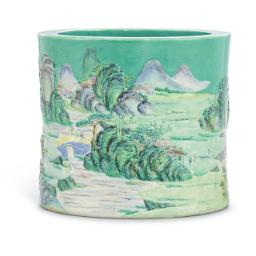

In [6]:
# Comment out accordingly for local / colab

# For local
# show_image("./data/train/brushpot/bp_51.png")

# For colab
show_image(f"{path}/data/train/brushpot/bp_51.png")

### Changjingping (Long Neck Vase)
Will be using *cjp* in short for labelling

Some of these vases can be easily mistaken as Tianqiuping by new antique collectors. Changjinping has angled shoulders, squat body and an elegant long neck.

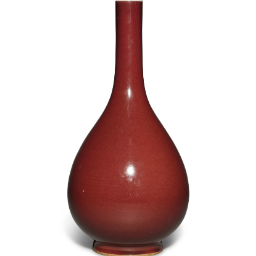

In [7]:
# Comment out accordingly for local / colab

# For local
# show_image("./data/train/cjp/cjp_4.png")

# For colab
show_image(f"{path}/data/train/cjp/cjp_4.png")


### Jar

Jars are identified by rounded shapes, small mouths, and high-shoulders. The jars were usually used to store and transport spices.

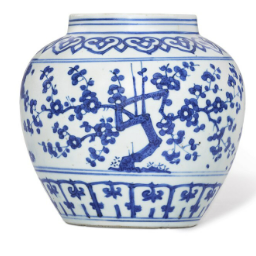

In [8]:
# Comment out accordingly for local / colab

# For local
# show_image("./data/train/jar/jar_36_s.png")

# For colab
show_image(f"{path}/data/train/jar/jar_36_s.png")

### Meiping (Plum vase)

Meiping, literally meant “plum vase”. It is characterized by a small neck, narrow mouth, with tall broad shoulders, and a tall body. They were designed for storing wine during Tang dynasty. While in the later period, it was used for a variety of purposes such as flower vases.

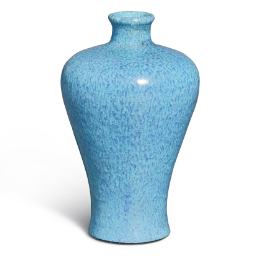

In [9]:
# Comment out accordingly for local / colab

# For local
# show_image("./data/train/meiping/mp_64_s.png")

# For colab
show_image(f"{path}/data/train/meiping/mp_64_s.png")

### Tian Qiu Ping (Globular vase)
Will be using *tqp* in short for labelling

The Tianqiuping vases were popular within the royalties. The vases are characterised by long necks and  globe-shaped bodies. The vase resembles the rounded celestial sphere and it is vast. This is because it represents heaven. The ancient Chinese believed that China was the middle kingdom of a flat Earth and their emperor is an intermediary between heaven and Earth.

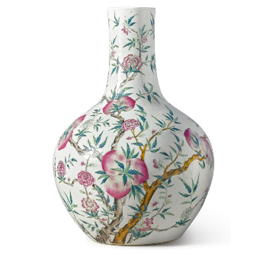

In [10]:
# Comment out accordingly for local / colab

# For local
# show_image("./data/train/tqp/tqp_40_s.png")

# For colab
show_image(f"{path}/data/train/tqp/tqp_40_s.png")

## Image Augmentation

Since the dataset collected is small, I used image augmentation to expand the size of my dataset. The different transformations or augmentation techniques applied to the original images are shifting, rotating, flipping, zooming, shearing and brightness adjustment. This also allow the model to learn images that were not taken perfectly which is likely to happen in real life. The very first technique used is rescaling. The images is in RGB coefficients which is in the 0-255, thus, by rescaling such high value with 1/255, the target values will be between 0 and 1.

In [11]:
train_datagen = ImageDataGenerator(
        rescale = 1/255,
        rotation_range = 20,
        zoom_range = 0.08,
        width_shift_range = 0.08,
        height_shift_range = 8,
        shear_range = 0.05,
        horizontal_flip = True,
        fill_mode = "nearest",
        brightness_range = [0.5, 1.5])

val_datagen = ImageDataGenerator(rescale = 1/255)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [12]:
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    target_size = (256, 256),
    shuffle = True,
    seed = 42)

valid_generator = train_datagen.flow_from_directory(
    directory = val_path,
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    target_size = (256, 256),
    shuffle = True,
    seed = 42)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    color_mode = "rgb",
    batch_size = 1,
    class_mode = None,
    target_size = (256, 256),
    shuffle = False,
    seed = 42)

Found 422 images belonging to 5 classes.
Found 105 images belonging to 5 classes.
Found 132 images belonging to 5 classes.


This dictionary is done by using train_generator.class_indices

In [13]:
# Creating a dictionary for mapping numeric values to classes
label_names = {0: "brushpot", 
               1: "cjp", 
               2: "jar", 
               3: "meiping", 
               4: "tqp"}

labels = list(label_names.values())
labels

['brushpot', 'cjp', 'jar', 'meiping', 'tqp']

### Previewing the augmented images

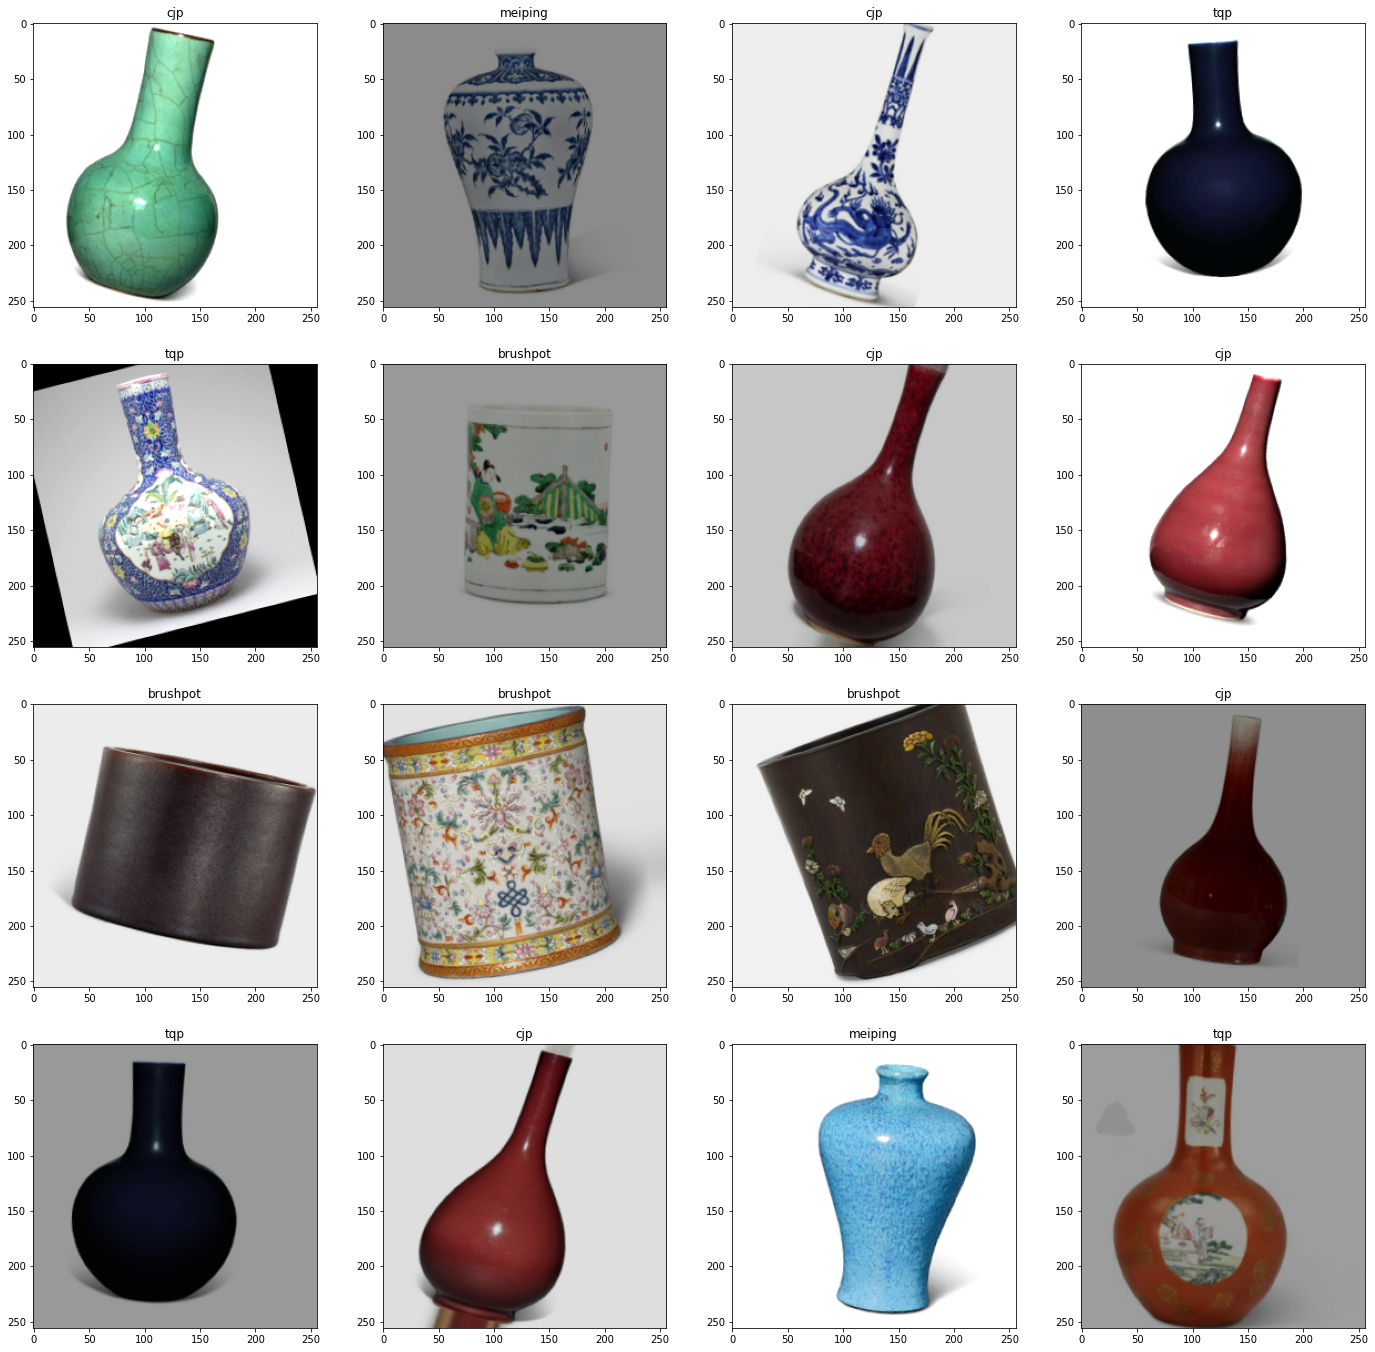

In [14]:
for X_batch, y_batch in train_generator:
  
    labels_no = list(train_generator.class_indices.values())

    fig, axes = plt.subplots(nrows = 4, 
                             ncols = 4, 
                             figsize=(24, 24))
    
    axes = axes.ravel()

    for i in range(0, 16):
        axes[i].imshow(X_batch[i].reshape(256, 256, 3))
        axes[i].set_title(labels[int(labels_no[y_batch[i].argmax(axis = -1)])])
    
    break

Creating 4 lists for:
- Model performance comparison: Model names, accuracy scores
- Model predictions: Model names, Y classes (predictions), Cm list (confusion matrix)

In [15]:
model_list = []
acc_score_list = []
y_classes_list = []
cm_list = []

## Modelling

### Image classification without using pre-trained model

#### Baseline model

In [16]:
base_model = keras.Sequential([keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
                               keras.layers.MaxPooling2D(pool_size=(2, 2)),
                               keras.layers.Flatten(),
                               keras.layers.Dense(32, activation="relu"),
                               keras.layers.Dense(16, activation="relu"),
                               keras.layers.Dense(5, activation="softmax")
                              ])

* First layer: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. ([source](https://keras.io/api/layers/convolution_layers/convolution2d/))
* Pooling layer: This layer is used for reducing the dimensions of the feature maps. In that, reduces the number of parameters to learn, as well as the computational effort in the network. I've used Max Pooling to extract maximum value.
* Flatten layer: This layer helps to convert matrix into single array
* Hidden layers: The rectified linear (ReLU(x)=max(0,X)) activation function allow models to learn faster and perform better.
* Top layer: Softmax is used as the activation function for multi-class classification problems. I have 5 class labels for prediction.

In [17]:
base_model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"])

* Loss: I've used cross-entropy for adjusting model weights during training. Cross-entropy measure the performance of a classification model with a probability value between 0 and 1. The smaller the loss the better the model. The categorical crossentropy is a loss function that is used in multi-class classification with probable match for each category.
* Optimizer: Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. Benefits of using adam can be found at ([source](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))
* Metrics: I've used accuracy since my datasets are quite balanced

In [18]:
history = base_model.fit(train_generator,
                         validation_data = valid_generator,
                         epochs = 40,
                         batch_size = 16)

Epoch 1/40
27/27 [==============================] - 155s 6s/step - loss: 8.7158 - accuracy: 0.2204 - val_loss: 1.6356 - val_accuracy: 0.2190
Epoch 2/40
27/27 [==============================] - 10s 374ms/step - loss: 1.5836 - accuracy: 0.2536 - val_loss: 1.6011 - val_accuracy: 0.2381
Epoch 3/40
27/27 [==============================] - 10s 376ms/step - loss: 1.5423 - accuracy: 0.2820 - val_loss: 1.8284 - val_accuracy: 0.2476
Epoch 4/40
27/27 [==============================] - 10s 375ms/step - loss: 1.5204 - accuracy: 0.2962 - val_loss: 1.6791 - val_accuracy: 0.2857
Epoch 5/40
27/27 [==============================] - 10s 377ms/step - loss: 1.5021 - accuracy: 0.3270 - val_loss: 1.6933 - val_accuracy: 0.2286
Epoch 6/40
27/27 [==============================] - 10s 376ms/step - loss: 1.4830 - accuracy: 0.3365 - val_loss: 1.7411 - val_accuracy: 0.3810
Epoch 7/40
27/27 [==============================] - 10s 378ms/step - loss: 1.4933 - accuracy: 0.3436 - val_loss: 1.5939 - val_accuracy: 0.3333
E

In [19]:
score = base_model.evaluate(valid_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

7/7 [==============================] - 2s 296ms/step - loss: 1.6007 - accuracy: 0.4667
Test loss: 1.600658893585205
Test accuracy: 0.46666666865348816


Plotting accuracy and loss for modelling without pre-trained models

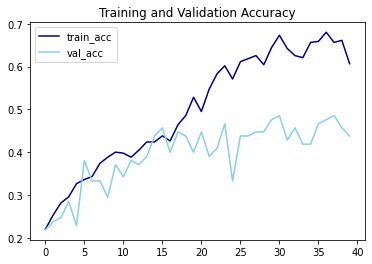

In [20]:
plt.plot(history.history["accuracy"], 
         label="train_acc", 
         color="navy")

plt.plot(history.history["val_accuracy"], 
         label="val_acc", 
         color="skyblue")

plt.title("Training and Validation Accuracy")

plt.legend()

plt.show()

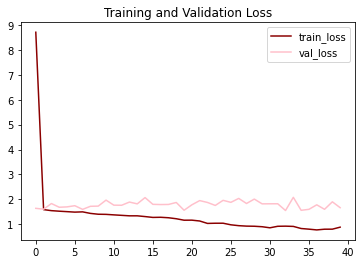

In [21]:
plt.plot(history.history["loss"], 
         label="train_loss", 
         color="darkred")

plt.plot(history.history["val_loss"], 
         label="val_loss", 
         color="pink")

plt.title("Training and Validation Loss")

plt.legend()

plt.show()

Using the model above to predict on the test set

In [23]:
# Predict on the test data
predict = base_model.predict(test_generator, 
                             steps = len(test_generator.filenames))
y_classes = predict.argmax(axis=-1)

In [24]:
y_classes_alpha = (pd.Series(y_classes)).map(label_names)

Compile the prediction into a dataframe

In [25]:
# Creating a dataframe to store the results
results = pd.DataFrame(data = y_classes_alpha, columns = ["Prediction"])
results.index = results.index + 1

In [77]:
# Creating a new column for the actual value
results["Actual"] = "brushpot"
results["Actual"][28:55] = "cjp"
results["Actual"][55:81] = "jar"
results["Actual"][81:111] = "meiping"
results["Actual"][111:] = "tqp"

In [78]:
# Creating a new column to compare prediction and actual

# Define conditions
conditions = [results["Prediction"] == results["Actual"], 
              results["Prediction"] != results["Actual"]]

# Define choices
choices = ["Y", "N"]

results["Correct"] = np.select(conditions, choices)

Use value count to find the counts of each scenario

In [30]:
accuracy_score(test_generator.classes, y_classes)

0.4772727272727273

Show the confusion matrix for the baseline model

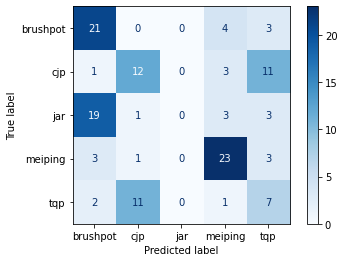

In [32]:
cm = confusion_matrix(test_generator.classes, y_classes)

cmd = ConfusionMatrixDisplay(cm, 
                             display_labels=["brushpot", 
                                             "cjp",
                                             "jar", 
                                             "meiping", 
                                             "tqp"])

cmd.plot(cmap="Blues")

**Findings for baseline model**
* The accuracy is 47.7%
* Meiping class was generally predicted best compared to the other classes with 23 images predicted correctly (76.7%).
* There are no prediction for jar with 19 of the jars being predicted as brushpot
* Coincidentally, there are 11 tqp images predicted wrongly as cjp and vice versa.
* The result is as expected since jar & brushpot were selected based on similarity in shapes. Likewise, for cjp and tqp.

### Image Classification with Pre-trained models

The pre-trained models are: VGG19, MobileNetV2 and ResNet50. 
<br>
For this modelling stage with pre-trained models, the following configurations were done:
* Top layer was not included
* All layers in the pre-trained model freezed
* Addtional layers were added to the model 
* The model checkpoint is the only callback included to save out the weights
* Learning rate is fixed

Expanding the 3rd configuration mentioned above:
* Pooling layer: I've used Average Pooling to extract average value.
* Dropout layer: This refers to neurons chosen at random to be not considered during a particular forward or backward pass during the training phase.

In [35]:
def pretrain_model(model_name, model, checkpoint_path):
    
    # Append model name for model comparison later
    model_list.append(model_name)

    # Transfer learning
    model_name = keras.models.Sequential()

    model_name.add(model(input_shape=[256, 256, 3], 
                         weights="imagenet", 
                         include_top = False))

    for layer in model_name.layers:
        layer.trainable = False
        
    # Add the more layers for predicting the 5 classes
    model_name.add(GlobalAveragePooling2D())
    model_name.add(Dense(1280, activation = "relu"))
    model_name.add(Dropout(0.5))
    model_name.add(Flatten())
    model_name.add(Dense(5, activation = "softmax"))
    model_name.summary()

    model_name.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"])
    
    # Creating checkpoint for saving the best weights out
    checkpoint = ModelCheckpoint(checkpoint_path, 
                                 monitor="val_accuracy", 
                                 verbose=1, 
                                 save_best_only=True,
                                 save_weights_only = True, 
                                 mode="max")     

    
    # Train the model
    history = model_name.fit(train_generator,
                             validation_data = valid_generator,
                             epochs=40,
                             callbacks=[checkpoint])

    
    # PLotting graphs for accuracy and loss
    plt.plot(history.history["accuracy"], 
             label="train_acc", 
             color="navy")

    plt.plot(history.history["val_accuracy"], 
             label="val_acc", 
             color="skyblue")

    plt.title("Training and Validation Accuracy")

    plt.legend()

    plt.show()

    
    plt.plot(history.history["loss"], 
             label="train_loss", 
             color="darkred")

    plt.plot(history.history["val_loss"], 
             label="val_loss", 
             color="pink")

    plt.title("Training and Validation Loss")

    plt.legend()

    plt.show()
    
    # Predict on the test data
    predict = model_name.predict(test_generator)
    y_classes = predict.argmax(axis=-1)
    y_classes_alpha = (pd.Series(y_classes)).map(label_names)
    y_classes_list.append(y_classes)

    # Show the accuracy score for this model
    accuracy = accuracy_score(test_generator.classes, y_classes)
    print(f"Accuracy Score for {model_name}") 
    print(accuracy)

    
    # Create the confusion matrix
    cm = confusion_matrix(test_generator.classes, y_classes)
    cm_list.append(cm)

    cmd = ConfusionMatrixDisplay(cm, 
                                 display_labels=["brushpot", 
                                                 "cjp",
                                                 "jar", 
                                                 "meiping", 
                                                 "tqp"])

    cmd.plot(cmap="Blues")
    
    acc_score_list.append(accuracy)

#### VGG19

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1280)              656640    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 

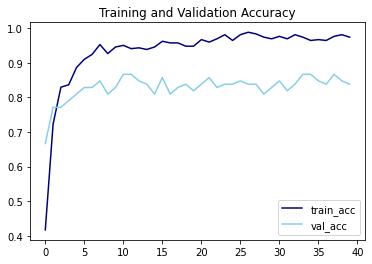

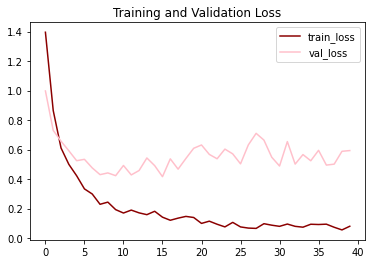

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7fb066546350>
0.8484848484848485


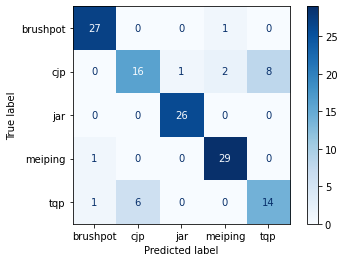

In [36]:
# Comment out accordingly for local / colab

# For local
# pretrain_model("VGG19", 
#                VGG19, 
#                "./models/vgg19_weight.h5")

# For colab
pretrain_model("VGG19", 
               VGG19, 
               f"{path}/models/vgg19_weight.h5")

**Findings for VGG19 model**

* The accuracy is 84.8%
* This is a great improvement from the baseline model earlier (47.7% accuracy)
* Jar class was predicted perfectly with all 26 jar images were predicted correctly.
* Meiping and Brushpot did well with only 1 image each got predicted wrongly.
* The trickiest 2 classes (cjp and tqp) generally performed better than baseline model.

#### MobileNetV2

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1280)              1639680   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                         

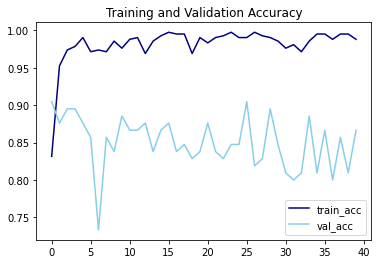

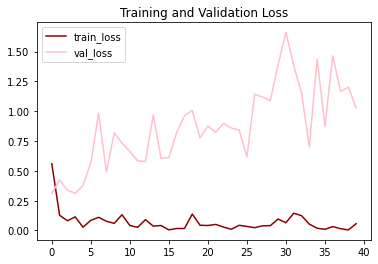

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7fb040709710>
0.8560606060606061


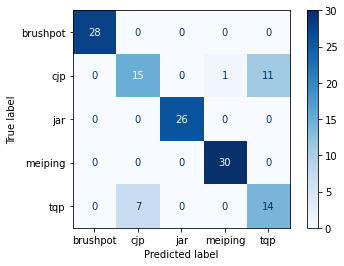

In [37]:
# Comment out accordingly for local / colab

# For local
# pretrain_model("MobileNetV2", 
#                MobileNetV2, 
#                "./models/mobilenetv2_weight.h5")

# For colab
pretrain_model("MobileNetV2", 
               MobileNetV2, 
               f"{path}/models/mobilenetv2_weight.h5")

**Findings for MobileNetV2 model**

* The accuracy is 85.6%
* There is a slight improvement from the VGG19 model earlier (84.8% accuracy)
* Jar, Meiping and Brushpot classes were predicted perfectly.
* The tqp class prediction performed the same as VGG19, while, cjp class performed slightly worse than VGG19 model.

#### Resnet50

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1280)              2622720   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 5)                 

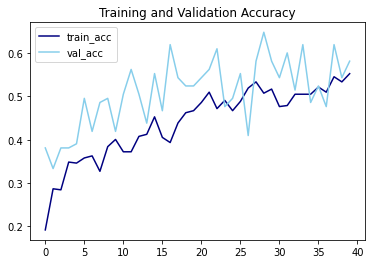

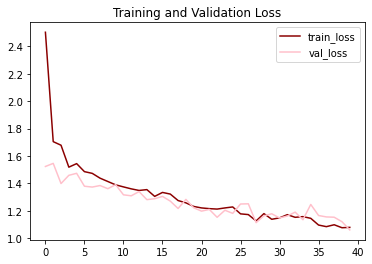

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7faf97e4bfd0>
0.48484848484848486


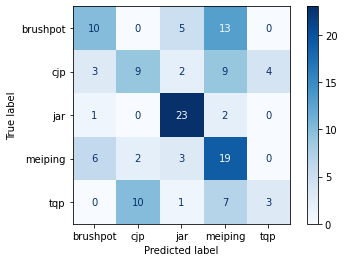

In [38]:
# Comment out accordingly for local / colab

# For local
# pretrain_model("Resnet50", 
#                ResNet50, 
#                "./models/resnet50_weight.h5")

# For colab
pretrain_model("Resnet50", 
               ResNet50, 
               f"{path}/models/resnet50_weight.h5")

**Findings for Resnet50 model**

* The accuracy is 48.5%
* This pretrained model performed the worst out of the 3.
* As shown in the confusion matrix, the predictions are more or less all over.
* However, one thing to note, the plots are better than the other 2 pretrained models.

### Fine Tuning Pre-trained models

For the third stage where I fine tune the pretrained models, the following were done:
* Freeze the first 10 layers of the model
* Add ReduceLROnPlateau as another callbacks to reduce the learning rate

*This fine tuning approach is based on keras documentation.* ([*source*](https://keras.io/guides/transfer_learning/))

In [39]:
def finetune_model(model_name, model, filepath):
    
    # Append model name for model comparison later    
    model_list.append(model_name)

    # Transfer learning    
    model_name = keras.models.Sequential()

    model_name.add(model(input_shape = [256, 256, 3], 
                         weights = "imagenet", 
                         include_top = False))

    for layer in model_name.layers[:10]:
        layer.trainable = False
    
    # Add more layers to the model
    model_name.add(GlobalAveragePooling2D())
    model_name.add(Dense(1280, activation = "relu"))
    model_name.add(Dropout(0.5))
    model_name.add(Flatten())
    model_name.add(Dense(5, activation = "softmax"))
    model_name.summary()

    model_name.compile(
        loss = "categorical_crossentropy",
        optimizer = 'adam',
        metrics = ["accuracy"])

    # Add one more callbacks
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.2,
                          patience = 3,
                          min_lr = 1e-06)
    
    # Creating checkpoint for saving the best weights out
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor = "val_accuracy", 
                                 verbose = 1, 
                                 save_best_only = True,
                                 save_weights_only = True, 
                                 mode = "max")
    
    
    # Train the model
    history = model_name.fit(train_generator,
                             validation_data = valid_generator,
                             epochs=40,
                             callbacks=[reduce_lr, checkpoint])

    
    # PLotting graphs for accuracy and loss    
    plt.plot(history.history["accuracy"], 
             label="train_acc", 
             color="navy")

    plt.plot(history.history["val_accuracy"], 
             label="val_acc", 
             color="skyblue")

    plt.title("Training and Validation Accuracy")

    plt.legend()

    plt.show()

    
    plt.plot(history.history["loss"], 
             label="train_loss", 
             color="darkred")

    plt.plot(history.history["val_loss"], 
             label="val_loss", 
             color="pink")

    plt.title("Training and Validation Loss")

    plt.legend()

    plt.show()

    
    # Using the model to predict on test set    
    predict = model_name.predict(test_generator)
    y_classes = predict.argmax(axis=-1)
    y_classes_alpha = (pd.Series(y_classes)).map(label_names)
    y_classes_list.append(y_classes)

    
    # Show the accuracy score for this model
    accuracy = accuracy_score(test_generator.classes, y_classes) 
    print(f"Accuracy Score for {model_name}") 
    print(accuracy)

    # Create the confusion matrix
    cm = confusion_matrix(test_generator.classes, y_classes)
    cm_list.append(cm)

    cmd = ConfusionMatrixDisplay(cm, 
                                 display_labels=["brushpot", 
                                                 "cjp",
                                                 "jar", 
                                                 "meiping", 
                                                 "tqp"])

    cmd.plot(cmap="Blues")
    
    acc_score_list.append(accuracy)

#### VGG19

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1280)              656640    
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 6405      
                                                      

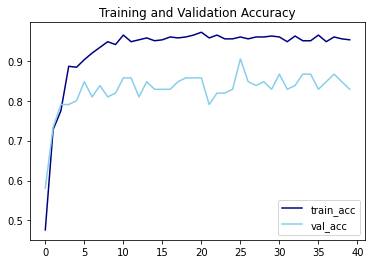

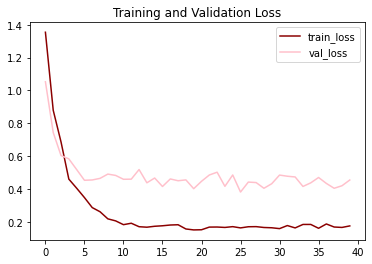

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7faf97a88d90>
0.8636363636363636


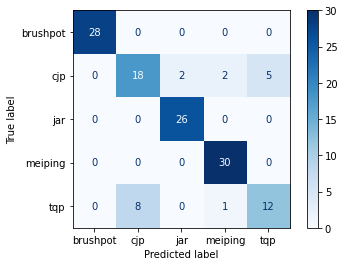

In [40]:
# Comment out accordingly for local / colab

# For local
# finetune_model("fine_vgg", 
#                VGG19, 
#                "./models/fine_vgg19_weight.h5")

# For colab
finetune_model("fine_vgg", 
               VGG19, 
               f"{path}/models/fine_vgg19_weight.h5")



**Findings for the fine tuned VGG19 model**

* The accuracy is 86.4%. 
* This is an improvement from the original VGG19 model (84.8% accuracy) and MobileNetV2 model (85.6% accuracy)
* Jar, Meiping and Brushpot classes were predicted perfectly. This result is same as MobileNetV2 and better than original VGG19.
* The number of images misclassified for cjp and tqp is the same.
* The learning rate was reduced to 1.6000e-06 for the best weights
* Since the dataset is small, overfitting is hard to avoid as shown by the plots

#### MobileNetV2

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 1280)              1639680   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 5)                

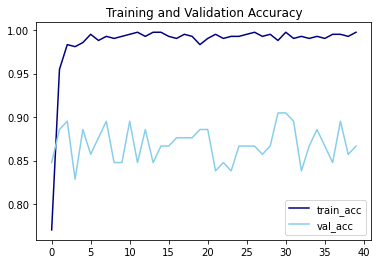

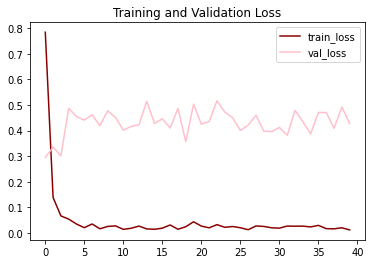

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7fb040098c90>
0.8560606060606061


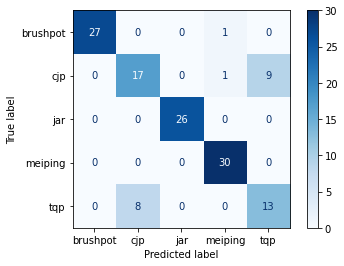

In [41]:
# Comment out accordingly for local / colab

# For local
# finetune_model("fine_MobileNetV2", 
#                MobileNetV2, 
#                "./models/fine_mobilenetv2_weight.h5")

# For colab
finetune_model("fine_MobileNetV2", 
               MobileNetV2, 
               f"{path}/models/fine_mobilenetv2_weight.h5")

**Findings for the fine tuned MobileNetV2 model**

* The accuracy is 85.6%.  
* This is the same as the original MobileNetV2 model but worse than the fine tuned VGG19 model (86.4% accuracy). 

#### Resnet 50

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 1280)              2622720   
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 5)                 6405      
                                                      

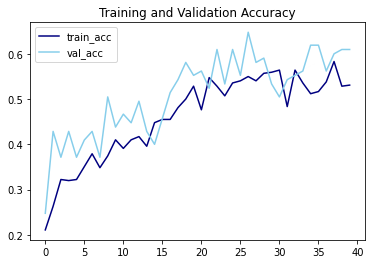

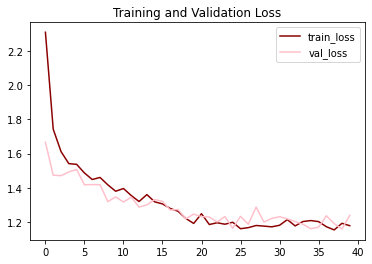

Accuracy Score for <keras.engine.sequential.Sequential object at 0x7fb04058ed10>
0.4318181818181818


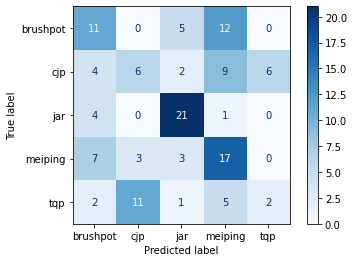

In [42]:
# Comment out accordingly for local / colab

# For local
# finetune_model("fine_Resnet50", 
#                ResNet50, 
#                "./models/fine_resnet50_weight.h5")

# For colab
finetune_model("fine_Resnet50", 
               ResNet50, 
               f"{path}/models/fine_resnet50_weight.h5")

**Findings for fine tuned Resnet50 model**

* The accuracy is 43.2%
* This is worse than the original resnet50 model.

## Model Comparison

Storing the prediction into a dataframe

In [46]:
model_prediction = pd.DataFrame({"models": model_list, 
                                 "y_classes_list": y_classes_list,
                                 "cm list": cm_list})

model_prediction.set_index("models", inplace = True)

model_prediction

,y_classes_list,cm list
models,,
VGG19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[[27, 0, 0, 1, 0], [0, 16, 1, 2, 8], [0, 0, 26..."
MobileNetV2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[28, 0, 0, 0, 0], [0, 15, 0, 1, 11], [0, 0, 2..."
Resnet50,"[0, 3, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 2, 3, 3, ...","[[10, 0, 5, 13, 0], [3, 9, 2, 9, 4], [1, 0, 23..."
fine_vgg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[28, 0, 0, 0, 0], [0, 18, 2, 2, 5], [0, 0, 26..."
fine_MobileNetV2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[[27, 0, 0, 1, 0], [0, 17, 0, 1, 9], [0, 0, 26..."
fine_Resnet50,"[0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 2, 3, 3, ...","[[11, 0, 5, 12, 0], [4, 6, 2, 9, 6], [4, 0, 21..."


Appending base model and base model accuracy score for model comparison

In [47]:
model_list.append("Base model")

In [48]:
acc_score_list.append(accuracy_score(test_generator.classes, y_classes))

In [49]:
model_comparision = pd.DataFrame({"models": model_list, 
                                  "accuracy score": acc_score_list})

model_comparision.set_index("models", inplace = True)

model_comparision

,accuracy score
models,
VGG19,0.848485
MobileNetV2,0.856061
Resnet50,0.484848
fine_vgg,0.863636
fine_MobileNetV2,0.856061
fine_Resnet50,0.431818
Base model,0.477273


Fine tuned VGG19 model performed best out of the 7 models with 86.4% accuracy.

## Misclassified images

Extracting the images used for test set

In [105]:
x_test=[]

for folder in sorted(os.listdir(test_path)):
  sub_path=test_path+"/"+folder

  for img in os.listdir(sub_path):

      image_path=sub_path+"/"+img
      img_arr=cv2.imread(image_path)
      img_arr=cv2.resize(img_arr,(256,256))

      x_test.append(img_arr)

brushpot
cjp
jar
meiping
tqp


<br>
Replicating the confusion matrix for fine tuned VGG19 model

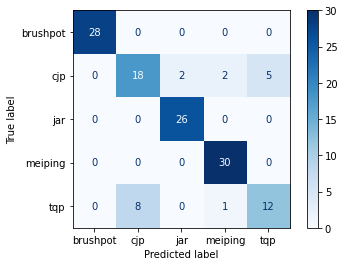

In [50]:
cm = model_prediction.loc["fine_vgg", "cm list"]

cmd = ConfusionMatrixDisplay(cm, 
                             display_labels=["brushpot", 
                                             "cjp",
                                             "jar", 
                                             "meiping", 
                                             "tqp"])

cmd.plot(cmap="Blues")

Extracting prediction out from the model prediction dataframe

In [51]:
y_classes = model_prediction.loc["fine_vgg", "y_classes_list"]

Map the prediction to class labels

In [52]:
y_classes_alpha = (pd.Series(y_classes)).map(label_names)

In [54]:
test_generator_alpha = (pd.Series(test_generator.classes)).map(label_names)

Presenting the prediction and comparison for using fine tuned VGG19 model in dataframe format

In [93]:
results = pd.DataFrame(data = y_classes_alpha, columns = ["Prediction"])
results.index = results.index

In [94]:
results["Actual"] = "brushpot"
results["Actual"][28:55] = "cjp"
results["Actual"][55:81] = "jar"
results["Actual"][81:111] = "meiping"
results["Actual"][111:] = "tqp"

In [95]:
# Creating a new column to compare prediction and actual

# Define conditions
conditions = [results["Prediction"] == results["Actual"], 
              results["Prediction"] != results["Actual"]]

# Define choices
choices = ["Y", "N"]

results["Correct"] = np.select(conditions, choices)

In [96]:
results["Correct"].value_counts()

Y    114
N     18
Name: Correct, dtype: int64

In [97]:
results[results["Correct"] == "N"]

,Prediction,Actual,Correct
33,jar,cjp,N
35,meiping,cjp,N
36,meiping,cjp,N
37,tqp,cjp,N
38,tqp,cjp,N
39,tqp,cjp,N
40,tqp,cjp,N
41,jar,cjp,N
42,tqp,cjp,N
115,cjp,tqp,N


In a quick glance, we can see TQP and CJP are the only 2 classes with misclassification. This is as expected since the 2 shapes are similar to each other.

Extracting the indexes of misclassified images from the dataframe above

In [98]:
misclassified_list = [x for x in results[results["Correct"] == "N"].index]

(0.0, 1.0, 0.0, 1.0)

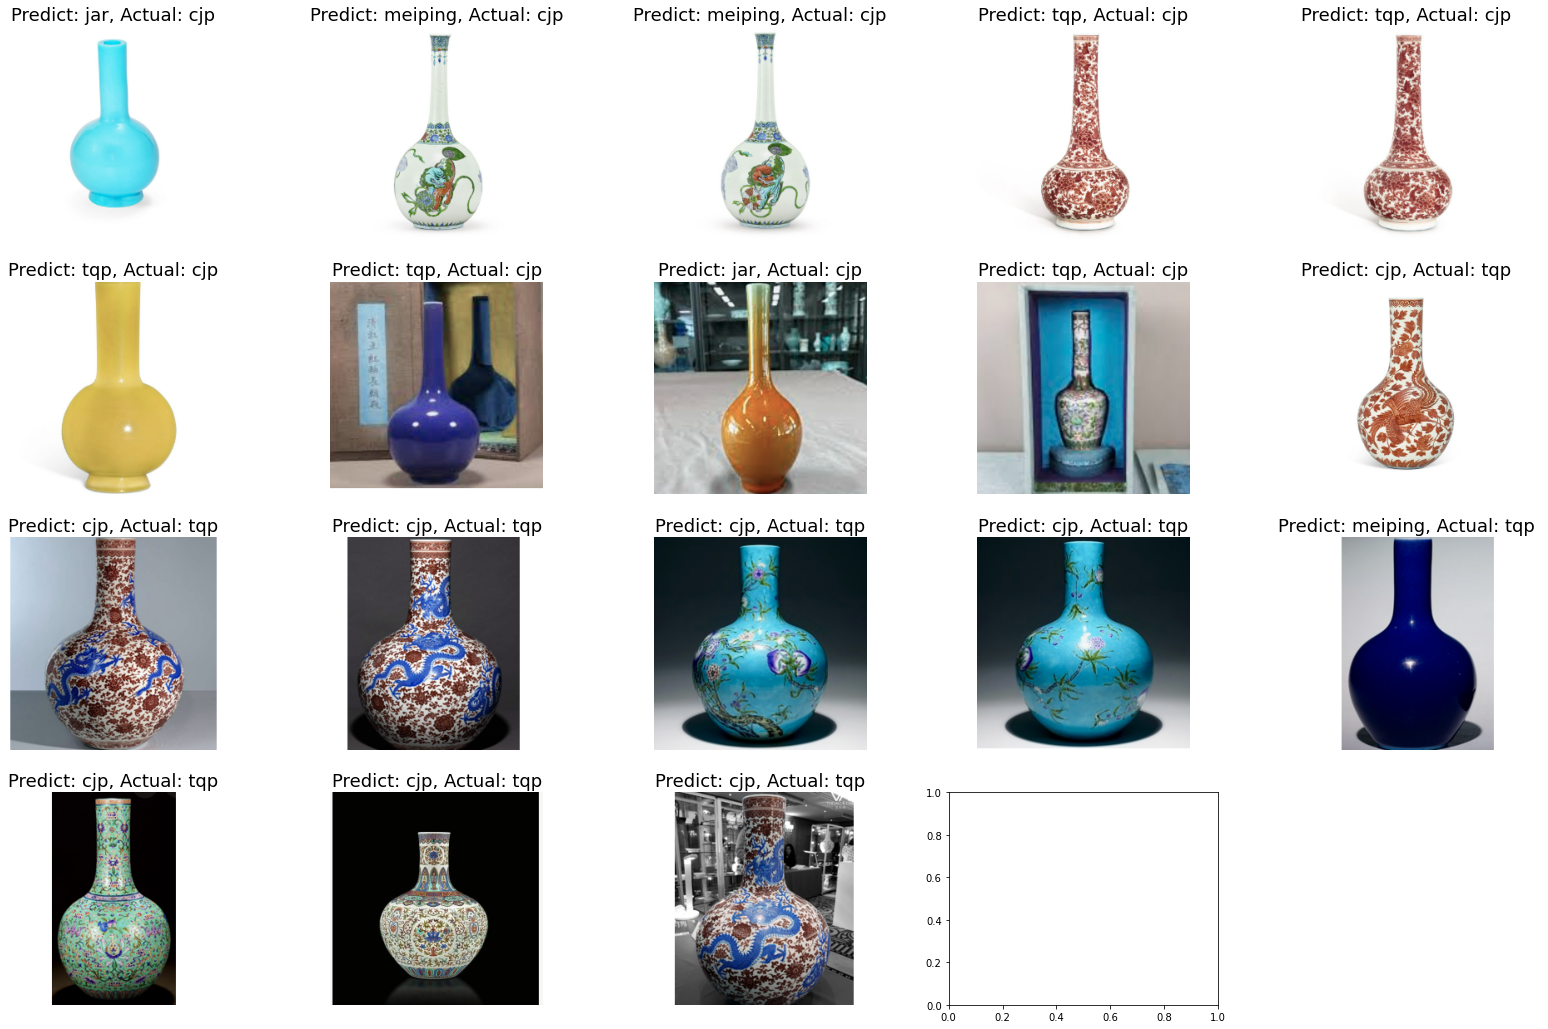

In [108]:
import matplotlib.pyplot as plt
misclassifiedIndexes = np.where(test_generator.classes != y_classes)[0]


fig, ax = plt.subplots(4, 5, figsize=(28,18))
ax = ax.ravel()

for i, misclass in enumerate(misclassified_list):
    ax[i].imshow(np.reshape(x_test[misclass], (256, 256, 3)))
    ax[i].set_title(f'Predict: {y_classes_alpha[misclass]}, '
                    f'Actual: {test_generator_alpha[misclass]}', fontsize = 18)
    ax[i].set(frame_on=False)
    ax[i].axis('off')
    
plt.box(False)
plt.axis('off')

It is quite pleasing to see the misclassified images are not mainly for those with noisy backgrounds. There are only 5 images out of 18 misclassifed images with noisy background.

## Conclusion

### Summary on model chosen

I've chosen the fine tuned VGG19 model for classifying chinese antique porcelain shapes.
<br>
Baseline Model Accuracy: 47.7%
<br>
**Fine Tuned VGG19 model: 86.4%**


* Jar, Meiping and Brushpot classes were predicted perfectly.
* The number of images misclassified for cjp and tqp is the same at 9.
* The learning rate was reduced to 1.6000e-06 for the best weights

### Uses for this classifier

The classifier can be used for new chinese antique collectors interested in collecting the 5 classes: Brushpot, Jar, Meiping, Chang Jing Ping and Tian Qiu Ping. By using the classifier, they can get one of the basic about the chinese antique porcelain right.

This classifier can also be used as a stepping stone for classifying chinese antiques by dynasty. This can even further evaluate the porcelain value.

### Future Work

* To collect more data for all existing classes
* Increase the number of classes to  predict
* To do object detection
* Evolve to dynasty classifier for the porcelain pieces

## References

Chinese Antique Market popularity in terms of monetary value: https://cn.artnet.com/en/chinese-art-auction-market-report/

Research on the thumbrule for image size: https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network

Keras documantation on Conv2d: https://keras.io/api/layers/convolution_layers/convolution2d/

Using ADAM as optimizer: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

Fine tuning approach based on keras documentation: https://keras.io/guides/transfer_learning/